# Import and Connection

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
path = '/gdrive/MyDrive/DM_Project'

In [3]:
!ls

sample_data


In [4]:
%cd '../gdrive/MyDrive/DM_Project'

/gdrive/MyDrive/DM_Project


In [22]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import pprint
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# !pip install seaborn

In [6]:
df = pd.read_csv('AmazonFashionReviewFinal5.csv', index_col=0)
df = df.fillna('')

In [7]:
df.head()

overall  ...                          cleaned_full_product_text
0      5.0  ...  milliongadget ear safeti back fish hook small ear
1      2.0  ...  milliongadget ear safeti back fish hook small ear
2      4.0  ...  milliongadget ear safeti back fish hook small ear
3      2.0  ...  milliongadget ear safeti back fish hook small ear
4      3.0  ...  milliongadget ear safeti back fish hook small ear

[5 rows x 18 columns]

# Basic Preprocessing

Joining product meta data with main dataframe

In [58]:
np.unique(df.overall, return_counts=True)[1]*100/len(df)

array([12.12345687,  7.3271512 , 10.98262819, 16.88985997, 52.67690377])

In [ ]:
data = []
with open('meta_AMAZON_FASHION.json', 'r') as f:
    for l in f:
        data.append(json.loads(l.strip()))
meta = pd.DataFrame.from_dict(data)
meta.description = meta.description.str.join(' ')
meta=meta[['asin', 'title', 'description']].drop_duplicates()

finaldf = df.merge(meta[['asin', 'title', 'description']], on='asin', how="left")
finaldf = finaldf.fillna('')
finaldf['description'] = finaldf['description'].astype(str)
finaldf['full_product_text'] = finaldf[['title', 'description']].agg(' '.join, axis=1)
finaldf[~(finaldf.description == '')]
finaldf.to_csv(os.path.join(path, 'AmazonFashionReviewFinal4.csv'))

Creating label and Score from sentiment classification results. Since inference takes a lot of time on our dataset, we had to pickle and see the results.

In [ ]:
import pickle
pickle_in = open("results.pickle","rb")
results = pickle.load(pickle_in)
results1 = pd.DataFrame(results)

df['label'] = results1['label']
df['score'] = results1['score']

# Exploratory Data Analysis

Categorical Variables Analysis



In [9]:
print('Overall Rating Distribution')
df.overall.value_counts()

Overall Rating Distribution


5.0    465067
4.0    149115
1.0    107034
3.0     96962
2.0     64689
Name: overall, dtype: int64

In [18]:
print("Total records with helpful votes for reviews")
len(df[~(df.vote == '')])

Total records with helpful votes for reviews


79483

In [10]:
# The length of each review as a new column in our analysis
df['len_review'] = df['reviewText'].str.split().apply(len)

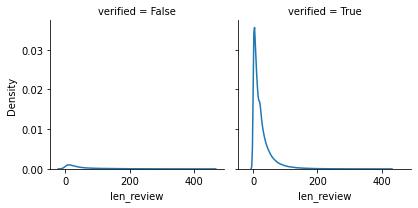

In [15]:
# Effect of verified on length of review

col = 'verified'
sns.displot(
    df, x="len_review", col=col, kind="kde",
    height=3, facet_kws=dict(margin_titles=True),
)

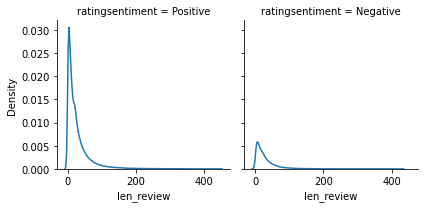

In [16]:
# Effect of rating sentiment on length of review

col = 'ratingsentiment'
sns.displot(
    df, x="len_review", col=col, kind="kde",
    height=3, facet_kws=dict(margin_titles=True),
)

In [35]:
# Just a helper viz function to plot a count plot of categorical variables

def plot_fun1(col_name, title, x_label, y_label):
  sns.set(rc={'figure.figsize':(3,3)})
  sns.set_style('whitegrid')
  va=sns.countplot(x=col_name, data=df, palette='rainbow')
  plt.xlabel(x_label, fontsize=15)
  plt.xticks(rotation=90)
  plt.ylabel(y_label, fontsize=15)
  plt.title(title, fontsize=20)

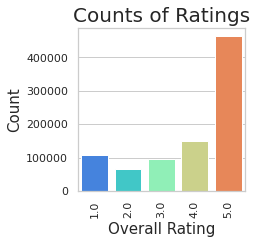

In [36]:
plot_fun1('overall', 'Counts of Ratings', 'Overall Rating', 'Count')

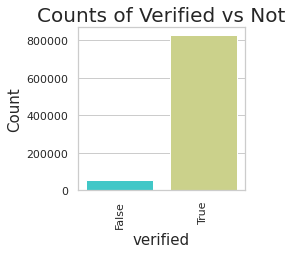

In [37]:
df['verified'].value_counts()
plot_fun1('verified', 'Counts of Verified vs Not', 'verified', 'Count')

In [ ]:
df[['ratingsentiment', 'label']].value_counts()

ratingsentiment  label   
Positive         POSITIVE    606941
Negative         NEGATIVE    154889
Positive         NEGATIVE    104203
Negative         POSITIVE     16834
dtype: int64

In [ ]:
# new_df = new_df.reset_index()

In [ ]:
print(df.verified.value_counts())
new_df.verified.value_counts()

True     828294
False     54573
Name: verified, dtype: int64


True     113864
False      7173
Name: verified, dtype: int64

In [ ]:
idx = np.random.randint(len(new_df))
print(new_df.fullReviewText.iloc[idx])
print(new_df.ratingsentiment.iloc[idx])
print(new_df.overall.iloc[idx])
print(new_df.label.iloc[idx])
print(new_df.score.iloc[idx])
# print(classifier(new_df.fullReviewText.iloc[idx]))

If you have ass go a size up Runs small
Positive
5.0
NEGATIVE
0.9981725215911864


# Applying Transformer Based Text Sentiment Classification

In [ ]:
cols = ['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName', 'reviewText', 'summary', 'vote']
df = df[cols]
df['ratingsentiment'] = df.apply(lambda x: 'Positive' if (x['overall'] >= 3.0) else 'Negative', axis=1)
df['fullReviewText'] = df[['reviewText', 'summary']].agg(' '.join, axis=1)
df.head()
df.to_csv(os.path.join(path, 'AmazonFashionReviewFinal.csv'))

In [ ]:
!pip install transformers

## Sentiment Classification for mismatch analysis

In [44]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
sentiment_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", max_length=512)
sentiment_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
sentiment_classifier = pipeline('sentiment-analysis', model=sentiment_model, tokenizer=sentiment_tokenizer)
feature_extractor = pipeline('feature-extraction', model=sentiment_model, tokenizer=sentiment_tokenizer)

In [41]:
feature_extractor(df.fullReviewText.iloc[1])

[[2.8671114444732666, -2.4541244506835938]]

In [50]:
idx = np.random.randint(len(df))
sequence_to_classify = df.fullReviewText.iloc[idx]
print(sequence_to_classify)
sentiment_classifier(sequence_to_classify)

Have purchased PajamaJeans traditional blue jeans look and was thrilled to discover the black and khaki colors. My husband is partially paralyzed and unable to walk. PajamaJeans are 1) easy for us to dress him while he is lying down 2) comfortable for him sitting in his wheelchair 3) look like regular jeans/pants 4) don't wrinkle 5) wash great and don't fade. Note: Like all our clothes I wash them, dry them on a low cycle for a short time, and hang to dry. Every time he wears a pair. I am so very glad that this product exists and is affordable, too. Kudos to whoever designed and developed PajamaJeans! P.S. If you don't already, consider marketing to the disabled community PajamaJeans are 1) easy for us to dress him while he is lying ...


[{'label': 'POSITIVE', 'score': 0.9459044337272644}]

In [ ]:
cols = ['fullReviewText']
df1 = df[cols]
dataset = Dataset.from_pandas(df1)

In [ ]:
from tqdm import tqdm
full_review_text = list(df.fullReviewText)
remove_ids = []
for i, review in tqdm(enumerate(full_review_text)):
  tokens = tokenizer(review)
  if len(tokens['input_ids']) > 500:
    remove_ids.append(i)

In [ ]:
len(remove_ids)
rows = df.index[remove_ids]
new_df = df.drop(rows, inplace=False)
new_df.to_csv(os.path.join(path, 'AmazonFashionReviewFinal.csv'))

In [ ]:
assert (len(df) - len(df.drop(rows, inplace=False))) == len(remove_ids)

In [ ]:
full_review_text = list(df.fullReviewText)
results = classifier(full_review_text)

In [ ]:
import pickle
pickle_out = open("dict.pickle","wb")
pickle.dump(results, pickle_out)
pickle_out.close()

In [ ]:
from tqdm import tqdm

results = []
for i, review in tqdm(enumerate(full_review_text)):
    try:
        result = classifier(review)
        results.append(result)
    except RuntimeError:
        # if num token > 512 just run on summary
        review = df.summary.iloc[i]
        result = classifier(review)
        results.append(result)
        continue

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
pt_model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

pt_batch = tokenizer(
    full_review_text,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

In [ ]:
pt_outputs = pt_model(**pt_batch)

In [ ]:
sample_text = list(df.reviewText[:100])
sample_rating = list(df.overall[:100])
sample_results = classifier(sample_text)
for i, result in enumerate(sample_results):
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}", sample_rating[i])
for i, j in zip(sample_text, sample_results):
    print(i, ' -> ', j)

## Emotion Classification for mismatch analysis
Distilbert-base-uncased-emotion


In [ ]:
from transformers import pipeline
emotion_classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=False, device=0)
emotion_classifier("I love using transformers. The best part is wide range of support and its easy to use")

[{'label': 'joy', 'score': 0.9959298968315125}]

In [ ]:
mask_pos_NEG = (df.ratingsentiment=='Positive') & (df.label=='NEGATIVE')
mask_neg_POS = (df.ratingsentiment=='Negative') & (df.label=='POSITIVE')
print(len(df[mask_pos_NEG]))
print(len(df[mask_neg_POS]))
new_df = df[mask_pos_NEG | mask_neg_POS]
new_df.head()

104203
16834


overall  ...  len_review
14      4.0  ...          79
15      3.0  ...          31
18      4.0  ...          47
19      3.0  ...          16
25      4.0  ...          51

[5 rows x 19 columns]

In [ ]:
full_review_text = list(new_df.fullReviewText)
results = emotion_classifier(full_review_text)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# results_df.to_csv('emotion_ratings.csv')

In [ ]:
results_df = pd.read_csv('emotion_ratings.csv')

In [ ]:
results_df.index = new_df.index

In [ ]:
# results_df = pd.DataFrame(results, index=new_df.index)
emotion_to_sentiment = {'joy': 'POSITIVE', 'suprise':'POSITIVE', 'love':'POSITIVE', 'sadness':'NEGATIVE', 'anger':'NEGATIVE', 'fear':'NEGATIVE'}

In [ ]:
# results_df.label = results_df.label.astype('category')
results_df.label[(results_df['label'] == 'joy')] = 'POSITIVE'
results_df.label[(results_df['label'] == 'suprise')] = 'POSITIVE'
results_df.label[(results_df['label'] == 'love')] = 'POSITIVE'
results_df.label[(results_df['label'] == 'sadness')] = 'NEGATIVE'
results_df.label[(results_df['label'] == 'anger')] = 'NEGATIVE'
results_df.label[(results_df['label'] == 'fear')] = 'NEGATIVE'

In [ ]:
print(len(df))
print(len(new_df))
print((len(df)- len(new_df))/len(df))

882867
121037
0.862904605110396


In [ ]:
mask_pos_NEG = (new_df.ratingsentiment=='Positive') & (results_df.label=='NEGATIVE')
mask_neg_POS = (new_df.ratingsentiment=='Negative') & (results_df.label=='POSITIVE')
len(new_df[(mask_pos_NEG | mask_neg_POS)])

43425

In [ ]:
(882867-22511)/882867

0.9745023882419436

In [ ]:
new_df1 = new_df[(mask_neg_POS)]
idx = np.random.randint(len(new_df1))
print(new_df1.fullReviewText.iloc[idx])
print(new_df1.ratingsentiment.iloc[idx])
print(new_df1.overall.iloc[idx])
print(new_df1.label.iloc[idx])
print(new_df1.score.iloc[idx])

Very cool dress, but you cant wear it as a dress unless you like ur ass hanging out. Looks cool with legging and a pair of boots! Not long enough to be a dress!
Negative
2.0
POSITIVE
0.9904791712760924


# Topic Modeling using Gensim, Spacy

In [ ]:
# reviews_corpus = list(df.fullReviewText)

In [ ]:
# # Create a set of frequent words
# stoplist = set('for a of the and to in'.split(' '))

# texts = [[word for word in document.lower().split() if word not in stoplist]
#          for document in review_corpus]

# # Count word frequencies
# from collections import defaultdict
# frequency = defaultdict(int)
# for text in texts:
#     for token in text:
#         frequency[token] += 1

# # Only keep words that appear more than once
# processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]
# # pprint.pprint(processed_corpus)

In [ ]:
# from gensim import corpora

# dictionary = corpora.Dictionary(processed_corpus)

/Users/rjsm3998/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Dictionary(109636 unique tokens: ['exactly', 'i', 'needed.', 'what', 'again']...)


In [ ]:
# new_doc = "Human computer interaction"
# new_vec = dictionary.doc2bow(new_doc.lower().split())
# print(new_vec)

[(5779, 1), (8544, 1), (72581, 1)]


In [ ]:
# bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]

In [ ]:
# from gensim import models

# # train the model
# tfidf = models.TfidfModel(bow_corpus)

# # transform the "system minors" string
# words = "fashion is stupid".lower().split()
# print(tfidf[dictionary.doc2bow(words)])


[(17, 0.12056432713777415), (3459, 0.6258276183151836), (10740, 0.7705868122254368)]


In [ ]:
# from gensim import similarities

# index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=12)

In [ ]:
# import spacy
# from spacy import displacy

# nlp = spacy.load('en_core_web_sm')
# doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#             token.shape_, token.is_alpha, token.is_stop)

In [ ]:
# text = """In ancient Rome, some neighbors live in three adjacent houses. In the center is the house of Senex, who lives there with wife Domina, son Hero, and several slaves, including head slave Hysterium and the musical's main character Pseudolus. A slave belonging to Hero, Pseudolus wishes to buy, win, or steal his freedom. One of the neighboring houses is owned by Marcus Lycus, who is a buyer and seller of beautiful women; the other belongs to the ancient Erronius, who is abroad searching for his long-lost children (stolen in infancy by pirates). One day, Senex and Domina go on a trip and leave Pseudolus in charge of Hero. Hero confides in Pseudolus that he is in love with the lovely Philia, one of the courtesans in the House of Lycus (albeit still a virgin)."""
# doc = nlp(text)
# sentence_spans = list(doc.sents)
# displacy.serve(sentence_spans, style="dep")

In [ ]:
# docs = list(nlp.pipe(review_corpus))

# Train and Apply Doc2Vec for review text

In [ ]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [ ]:
df['cleaned_full_product_text'] = df['full_product_text'].map(lambda x: clean_text(x))

In [ ]:
df.to_csv(os.path.join(path, 'AmazonFashionReviewFinal5.csv'))

In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Product2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=30):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['cleaned_full_product_text']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['cleaned_full_product_text']).split())
                                     for index, row in df_x.iterrows()]))

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=30):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['cleaned_full_review_text']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['cleaned_full_review_text']).split())
                                     for index, row in df_x.iterrows()]))


In [ ]:
doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vec_tr.fit(df)
product2vec_tr = Product2VecTransformer(vector_size=300)
product2vec_tr.fit(df)

In [ ]:
import gensim
gensim.utils.pickle(doc2vec_tr, 'doc2vec_model')
gensim.utils.pickle(product2vec_tr, 'product2vec_model')

In [ ]:
import pickle
pickle_in = open("product2vec_model","rb")
product2vec_tr = pickle.load(pickle_in)
# pickle_in = open("doc2vec_model","rb")
# doc2vec_tr = pickle.load(pickle_in)

In [ ]:
del(product2vec_tr)

In [ ]:
# doc2vec_tr._model = model
doc2vec_vectors = doc2vec_tr.transform(df)

In [ ]:
product2vec_vectors = product2vec_tr.transform(df)

In [ ]:
np.save('product2vec_vectors.npy', product2vec_vectors)

In [ ]:
product2vec_vectors = np.load('product2vec_vectors.npy')
doc2vec_vectors = np.load('doc2vec_vectors.npy')

In [ ]:
doc2vec_vectors.shape

(882867, 300)

In [ ]:
# del(product2vec_vectors)
del(doc2vec_vectors)

# Plotting doc2vec_vectors in 2d using IPCA, TSNE

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import time
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123
mask1 = ((df['label']=='POSITIVE') & (df['ratingsentiment']=='Negative'))
mask2 = ((df['label']=='NEGATIVE') & (df['ratingsentiment']=='Positive'))
# X = doc2vec_vectors[df.index[mask1 | mask2].tolist()]
# y = df.ratingsentiment[df.index[mask1 | mask2].tolist()]
df_sample = df.sample(int(0.1*len(df)))
X = np.array(doc2vec_vectors[df_sample.index.tolist()])
y = pd.factorize(df_sample.verified)[0]

In [ ]:
# def fashion_scatter(x, colors):
#     # choose a color palette with seaborn.
#     num_classes = len(np.unique(colors))
#     palette = np.array(sns.color_palette("hls", num_classes))

#     # create a scatter plot.
#     f = plt.figure(figsize=(8, 8))
#     ax = plt.subplot(aspect='equal')
#     sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
#     plt.xlim(-25, 25)
#     plt.ylim(-25, 25)
#     ax.axis('off')
#     ax.axis('tight')

#     # add the labels for each digit corresponding to the label
#     txts = []

#     for i in range(num_classes):

#         # Position of each label at median of data points.

#         xtext, ytext = np.median(x[colors == i, :], axis=0)
#         txt = ax.text(xtext, ytext, str(i), fontsize=24)
#         txt.set_path_effects([
#             PathEffects.Stroke(linewidth=5, foreground="w"),
#             PathEffects.Normal()])
#         txts.append(txt)

#     return f, ax, sc, txts

In [ ]:
from sklearn.manifold import TSNE
import time
time_start = time.time()
from sklearn.decomposition import PCA, IncrementalPCA

n_components = 50
ipca = IncrementalPCA(n_components=n_components, batch_size=100)
X_ipca = ipca.fit_transform(X)

In [ ]:
# from matplotlib.ticker import NullFormatter
# from sklearn import manifold, datasets
# n_components = 2
# (fig, subplots) = plt.subplots(3, 5, figsize=(15, 8))
# perplexities = [5, 30, 50, 100]

# ax = subplots[0][0]
# ax.scatter(X[red, 0], X[red, 1], c="r")
# ax.scatter(X[green, 0], X[green, 1], c="g")
# ax.xaxis.set_major_formatter(NullFormatter())
# ax.yaxis.set_major_formatter(NullFormatter())
# plt.axis("tight")

# for i, perplexity in enumerate(perplexities):
#     ax = subplots[0][i + 1]

#     t0 = time()
#     tsne = manifold.TSNE(
#         n_components=n_components, init="random", random_state=0, perplexity=perplexity
#     )
#     Y = tsne.fit_transform(X)
#     t1 = time()
#     print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
#     ax.set_title("Perplexity=%d" % perplexity)
#     ax.scatter(Y[red, 0], Y[red, 1], c="r")
#     ax.scatter(Y[green, 0], Y[green, 1], c="g")
#     ax.xaxis.set_major_formatter(NullFormatter())
#     ax.yaxis.set_major_formatter(NullFormatter())
#     ax.axis("tight")


In [ ]:
n_components = 2
perplexity = 50
mismatch_tsne = TSNE(n_components=n_components, init='random', random_state=RS, learning_rate='auto', perplexity=perplexity).fit_transform(X_ipca)

In [ ]:
!pip install umap-learn
!pip install plotly

In [ ]:
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(X)

fig_2d = px.scatter(
    proj_2d, x=0, y=1
)
fig_2d.show()

In [ ]:
from umap import UMAP
import plotly.express as px

umap_3d = UMAP(n_components=3, init='random', random_state=0)
proj_3d = umap_3d.fit_transform(X)
fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2
)
fig_3d.update_traces(marker_size=5)

fig_3d.show()

In [ ]:
# np.save('tsne2.npy', mismatch_tsne)

(<Figure size 576x576 with 1 Axes>,
 [Text(-0.10927831, -0.18394709, '0'), Text(-0.03428311, -0.24323262, '1')])

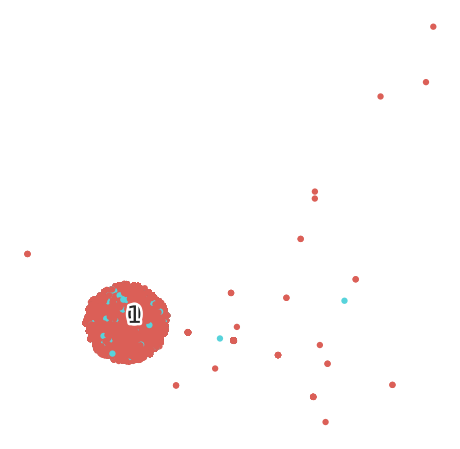

In [ ]:
# fashion_scatter(mismatch_tsne, y)

# Clustering in 3d space after tsne or umap

In [ ]:
from sklearn.cluster import OPTICS

clustering = OPTICS(min_samples=50).fit(proj_3d)

In [ ]:
!pip install joblib
from joblib import dump, load
dump(clustering, 'reviews_clustering_model.joblib') 

['reviews_clustering_model.joblib']

In [ ]:
clustering = load('reviews_clustering_model.joblib') 

In [ ]:
np.unique(clustering.labels_, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]),
 array([242817,     76,    142,    156,     59,     72,     68,     72,
           121,     51,     57,    251,     73,     61,     74,    429,
            85,    116,     97,     69,    107,     82,     8

In [ ]:
len(df_sample[clustering.labels_ == -1])/len(df_sample)

0.9167748999471419

# Outlier Detection in UMAP space

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(proj_3d)

In [ ]:
max(clf.negative_outlier_factor_)

-0.9231421620798386

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=100, warm_start=True)
clf.fit(X)

IsolationForest(warm_start=True)

In [ ]:
y_pred = clf.decision_function(X)

In [ ]:
sum(y_pred < 0)

7576

In [ ]:
len(y_pred)

88286

In [ ]:
df_sample[y_pred<0]

overall  ...                          cleaned_full_product_text
151632      5.0  ...  allegra ladi batw sleev zigzag pattern overs s...
667357      5.0  ...  pc gothic geometr knuckl urban finger midi cry...
583629      5.0  ...              ladi chiffon sleeveless vest tank top
516724      5.0  ...  voguebrid attack titan advanc giant cloak cost...
847780      4.0  ...  kid girl swimmabl mermaid tail sea maid bikini...
...         ...  ...                                                ...
317163      5.0  ...  soft wear women ladi medium long chiffon scarf...
392473      5.0  ...  mihol women lightweight long sleev criss cross...
703626      5.0  ...  babypajama big boi excav pajama set piec shirt...
703417      5.0  ...  abshoo lightweight canva backpack school bookb...
369031      5.0  ...  wonder beauti women latex sport girdl waist tr...

[7576 rows x 18 columns]